<a href="https://colab.research.google.com/github/RockhoRockho/Deep_Learning/blob/main/_7_1_%EC%BC%80%EB%9D%BC%EC%8A%A4_Word2Vec_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 케라스 Word2Vec 구현

* 참고: https://wikidocs.net/69141

### 전처리

In [5]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
documents = dataset.data

print(len(documents))
documents[1]

11314


"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

In [6]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]'
  text = re.sub(pattern, '', d)
  return text

def clean_stopword(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w not in stop_words and len(w) > 3])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
import pandas as pd

news_df = pd.DataFrame({'article':documents})
len(news_df)

11314

In [8]:
news_df.replace("", float("NaN"), inplace=True)
news_df.dropna(inplace=True)
len(news_df)

11096

In [9]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well im not sure about the story nad it did se...
1        \n\n\n\n\n\n\nYeah do you expect people to rea...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well I will have to change the scoring on my p...
                               ...                        
11309    Danny Rubenstein an Israeli journalist will be...
11310                                                   \n
11311    \nI agree  Home runs off Clemens are always me...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          \nNo arg...
Name: article, Length: 11096, dtype: object

In [10]:
news_df['article'] = news_df['article'].apply(clean_stopword)
news_df['article']

0        well sure story seem biased what disagree stat...
1        yeah expect people read actually accept hard a...
2        although realize principle strongest points wo...
3        notwithstanding legitimate fuss proposal much ...
4        well change scoring playoff pool unfortunately...
                               ...                        
11309    danny rubenstein israeli journalist speaking t...
11310                                                     
11311    agree home runs clemens always memorable kinda...
11312    used deskjet orange micros grappler system upd...
11313    argument murphy scared hell came last year han...
Name: article, Length: 11096, dtype: object

In [11]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()

In [12]:
import numpy as np

drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
news_texts = np.delete(tokenized_news, drop_news, axis=0)
print(len(news_texts))

10945


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

news_2000 = news_texts[:2000]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_2000)

idx2word = {value:key for key, value in tokenizer.word_index.items()}
sequences = tokenizer.texts_to_sequences(news_2000)

In [20]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

29769


In [16]:
print(sequences[1])

[1263, 457, 2, 60, 119, 419, 61, 1374, 22, 69, 3498, 397, 6874, 412, 1173, 373, 2256, 458, 59, 12478, 458, 1900, 3850, 397, 22, 10, 4325, 8749, 177, 303, 136, 154, 664, 12479, 316, 12480, 15, 12481, 4, 790, 12482, 12483, 4917, 8750]


### Skipgram

#### Skipgram 전처리

* 네거티브 샘플링(Negative Sampling)

  + Word2Vec은 출력층이 내놓는 값에 소프트맥스 함수를 적용해 확률값으로 변환한 후 이를 정답과 비교해 역전파(backpropagation)
  + 소프트맥스를 적용하려면 분모에 해당하는 값, 즉 중심단어와 나머지 모든 단어의 내적을 한 뒤, 이를 다시 exp 계산을 하는데 전체 단어가 많을 경우 엄청난 계산량 발생
  + 네거티브 샘플링은 소프트맥스 확률을 구할 때 전체 단어를 대상으로 구하지 않고, 일부 단어만 뽑아서 계산을 하는 방식
  + 네거티브 샘플링 동작은 사용자가 지정한 윈도우 사이즈 내에 등장하지 않는 단어(negative sample)를 5~20개 정도 뽑고, 이를 정답단어와 합쳐 전체 단어처럼 소프트맥스 확률을 계산하여 파라미터 업데이트

In [21]:
from tensorflow.keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in sequences[:10]]

In [22]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]
  ))

received(387), inning(6573) -> 0
clearly(580), what(34) -> 1
europe(1638), pubbsdportsxfree(18553) -> 0
realize(966), stay(748) -> 0
seem(173), letter(663) -> 1


In [23]:
print(len(skip_grams))
print(len(pairs))
print(len(labels))

10
2420
2420


In [25]:
skip_grams = [skipgrams(seq, vocabulary_size=vocab_size, window_size=10) for seq in sequences]

#### Skipgram 모델 구성

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model

In [27]:
embed_size = 50

In [28]:
def word2vec():
  target_inputs = Input(shape=(1, ), dtype='int32')
  target_embedding = Embedding(vocab_size, embed_size)(target_inputs)

  context_inputs = Input(shape=(1, ), dtype='int32')
  context_embedding = Embedding(vocab_size, embed_size)(context_inputs)

  dot_product = Dot(axes=2)([target_embedding, context_embedding])
  dot_product = Reshape((1, ), input_shape=(1, 1))(dot_product)
  output = Activation('sigmoid')(dot_product)

  model = Model(inputs=[target_inputs, context_inputs], outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam')

  return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        1488450     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        1488450     ['input_2[0][0]']                
                                                                                              

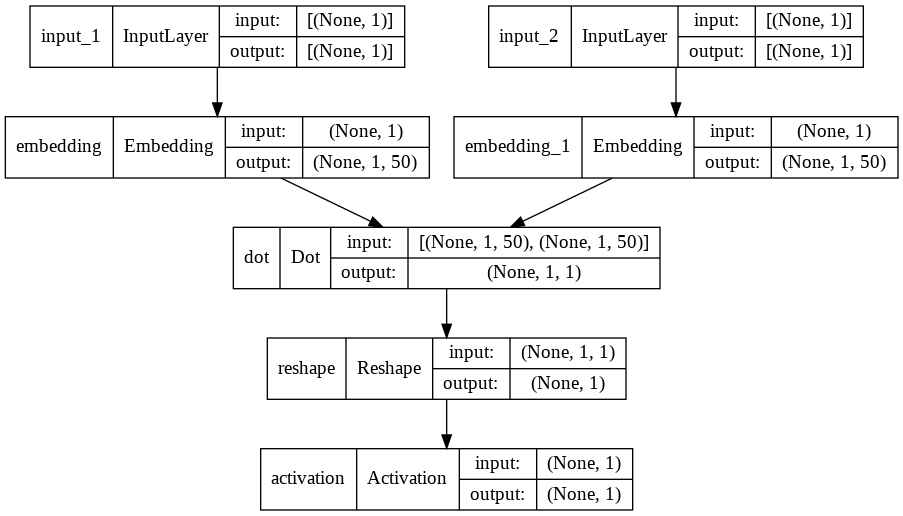

In [29]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [30]:
for epoch in range(1, 11):
  loss = 0
  for _, elem in enumerate(skip_grams):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)

  print('Epoch:', epoch, 'Loss:', loss)

Epoch: 1 Loss: 1227.5362813174725
Epoch: 2 Loss: 925.1938700377941
Epoch: 3 Loss: 827.7947991117835
Epoch: 4 Loss: 782.4215388521552
Epoch: 5 Loss: 756.0551255196333
Epoch: 6 Loss: 736.0899636223912
Epoch: 7 Loss: 716.2383469678462
Epoch: 8 Loss: 693.0582107156515
Epoch: 9 Loss: 665.0848555266857
Epoch: 10 Loss: 631.931894890964


In [31]:
import gensim

f = open('skipgram.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

skipgram = gensim.models.KeyedVectors.load_word2vec_format('skipgram.txt', binary=False)

In [37]:
skipgram.most_similar(positive=['soldier'])

[('traps', 0.838716447353363),
 ('indiscriminately', 0.8381505608558655),
 ('retalliates', 0.8132840991020203),
 ('israeli', 0.7230576276779175),
 ('pilots', 0.7207170128822327),
 ('booby', 0.7024158239364624),
 ('ammunitions', 0.689389169216156),
 ('bombing', 0.6836496591567993),
 ('killed', 0.6268077492713928),
 ('injured', 0.6171080470085144)]

In [36]:
skipgram.most_similar(positive=['world'])

[('dtommy', 0.6639333963394165),
 ('pexlib', 0.6620185375213623),
 ('afoot', 0.6352800130844116),
 ('eliminate', 0.6329780220985413),
 ('aheadthats', 0.6199167966842651),
 ('nflhershel', 0.6183429956436157),
 ('mays', 0.5922776460647583),
 ('rest', 0.5880638957023621),
 ('fashion', 0.5822910070419312),
 ('griffey', 0.5815346837043762)]

### CBOW


#### CBOW 전처리

In [46]:
def skipgram2cbow(skipgrams):
  cbows = []
  flag = 0
  for n in skipgrams:
    temp1 = []
    for t in n:
      if flag == 1:
        flag = 0
        temp1.append(t)
      else:
        flag = 1
        temp2 = []
        for x in t:
          temp2.append([x[1], x[0]])
        temp1.append(temp2)
    cbows.append(temp1)
  
  return cbows

In [47]:
cbows = skipgram2cbow(skip_grams)

In [48]:
pairs, labels = cbows[0][0], cbows[0][1]
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]
  ))

well(10), story(511) -> 1
roads(6392), described(1262) -> 0
seem(173), might(41) -> 1
subsidizing(8746), israels(3496) -> 1
plunder(17763), israels(3496) -> 0


In [49]:
print(len(cbows))
print(len(pairs))
print(len(labels))

2000
2420
2420


#### CBOW 모델 구성

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 50)        1488450     ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 50)        1488450     ['input_6[0][0]']                
                                                                                            

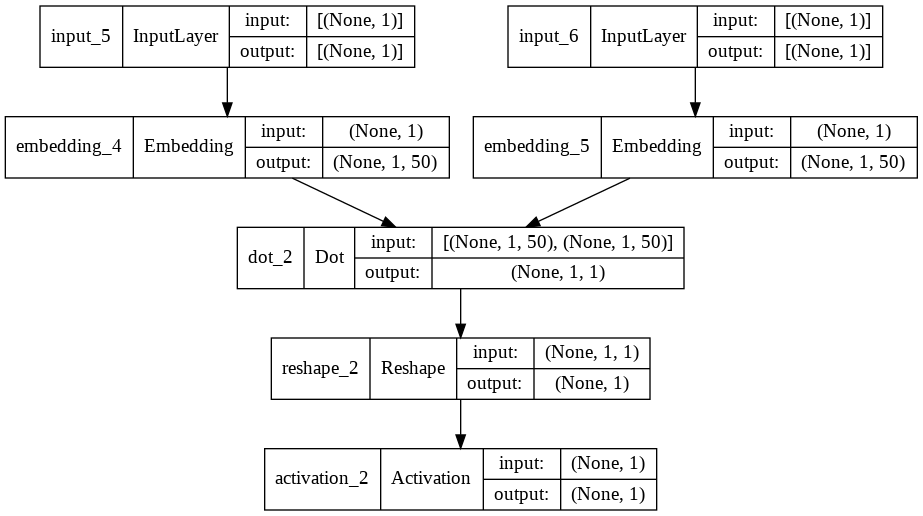

In [50]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [52]:
for epoch in range(1, 11):
  loss = 0
  for _, elem in enumerate(cbows):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)

  print('Epoch:', epoch, 'Loss:', loss)

Epoch: 1 Loss: 987.0451219379902
Epoch: 2 Loss: 854.5543500930071
Epoch: 3 Loss: 798.3306889906526
Epoch: 4 Loss: 768.1370473727584
Epoch: 5 Loss: 748.0634139031172
Epoch: 6 Loss: 730.0018188096583
Epoch: 7 Loss: 709.8021955117583
Epoch: 8 Loss: 684.9489965513349
Epoch: 9 Loss: 654.7862133458257
Epoch: 10 Loss: 619.4937854548916


In [57]:
import gensim

f = open('cbow.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

cbow = gensim.models.KeyedVectors.load_word2vec_format('cbow.txt', binary=False)

In [58]:
cbow.most_similar(positive=['soldier'])

[('traps', 0.9347949624061584),
 ('unconnectedunprivileged', 0.929385244846344),
 ('retalliates', 0.9287554025650024),
 ('pilots', 0.9266331791877747),
 ('sneak', 0.9258929491043091),
 ('booby', 0.9148087501525879),
 ('shitted', 0.9104068279266357),
 ('athravan', 0.9101314544677734),
 ('supernova', 0.9097453951835632),
 ('balding', 0.9080175161361694)]

In [59]:
cbow.most_similar(positive=['world'])

[('youre', 0.9512078166007996),
 ('years', 0.9503768682479858),
 ('want', 0.9476178884506226),
 ('hear', 0.9441068172454834),
 ('price', 0.942375659942627),
 ('good', 0.9415491223335266),
 ('idea', 0.9402512907981873),
 ('cards', 0.9386786818504333),
 ('doesnt', 0.9383195042610168),
 ('time', 0.9377083778381348)]